In [1]:
# General / Common libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import yfinance as yf
yf.pdr_override()

# Statistical Model(s)
from prophet import Prophet

# Deep Learning Model(s)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout

In [2]:
start, end = (datetime.today() - timedelta(days=365)).strftime("%Y-%m-%d"), datetime.today().strftime("%Y-%m-%d")
data = pdr.get_data_yahoo("AAPL", start=start, end=end)
close = data["Close"]

[*********************100%***********************]  1 of 1 completed


In [3]:
def sampling(sequence, n_steps):
    X, Y = list(), list()

    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)

    X, y = np.array(X), np.array(Y)
    return X, y

In [4]:
def plot_graph(expected, predicted):
    plt.plot(expected, label="Expected")
    plt.plot(predicted, label="Predicted")
    plt.legend()
    plt.show()

# Prophet

In [5]:
tailored_df = data.copy(deep=True)
tailored_df.reset_index(inplace=True)
tailored_df = tailored_df[["Date", "Close"]]
tailored_df.columns = ["ds", "y"]
tailored_df

,ds,y
0,2021-07-26,148.990005
1,2021-07-27,146.770004
2,2021-07-28,144.979996
3,2021-07-29,145.639999
4,2021-07-30,145.860001
...,...,...
246,2022-07-18,147.070007
247,2022-07-19,151.000000
248,2022-07-20,153.039993
249,2022-07-21,155.350006


In [6]:
prophet = Prophet()
prophet.fit(tailored_df)

22:14:44 - cmdstanpy - INFO - Chain [1] start processing
22:14:44 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = prophet.make_future_dataframe(periods=0, freq="D")

In [8]:
forecast = prophet.predict(future)
filtered_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
filtered_results

,ds,yhat,yhat_lower,yhat_upper
0,2021-07-26,147.143923,138.542155,154.668289
1,2021-07-27,147.596103,139.308774,155.978712
2,2021-07-28,147.781182,139.102543,156.174785
3,2021-07-29,147.306045,138.991113,155.162572
4,2021-07-30,147.005391,138.937492,155.311143
...,...,...,...,...
246,2022-07-18,138.158835,129.979943,146.348850
247,2022-07-19,138.381642,130.355847,147.053300
248,2022-07-20,138.337347,129.511883,147.207631
249,2022-07-21,137.632836,129.693602,145.769334


In [9]:
mean_absolute_percentage_error(tailored_df["y"], filtered_results["yhat"])

0.03244925827968415

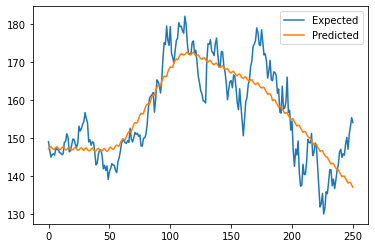

In [10]:
plot_graph(tailored_df["y"], filtered_results["yhat"])

# Deep Learning (LSTM)

In [11]:
X, y = sampling(close.tolist(), 24)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [16]:
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(24, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation="relu")))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mae")

In [17]:
model.fit(X, y, epochs=150, batch_size=32, verbose=0)

In [18]:
predictions = model.predict(X, verbose=0)

In [19]:
mean_absolute_percentage_error(y, predictions)

0.0955190752978043

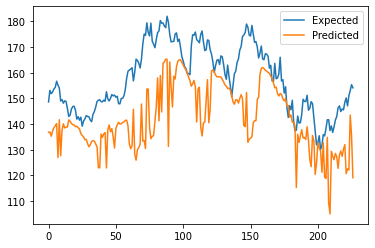

In [20]:
plot_graph(y, predictions)